<a href="https://colab.research.google.com/github/aekomissarova/dog_breed_classification/blob/main/dog_breed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification of dog breeds - https://www.kaggle.com/c/dog-breed-identification/overview 

In [1]:
#!unzip "/content/drive/MyDrive/dog_breed_classification/dog-breed-identification.zip" -d "/content/drive/MyDrive/dog_breed_classification"

In [2]:
# Import tensorFlow
import tensorflow as tf
print("TF version", tf.__version__)

TF version 2.9.2


In [3]:
#Import TensorFlow Hub
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)

TF Hub version: 0.12.0


In [4]:
#Check for GPU availability
print("GPU:","available" if tf.config.list_physical_devices("GPU") else "not available")

GPU: available


In [5]:
#Prepare data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

labels = pd.read_csv("/content/drive/MyDrive/dog_breed_classification/labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


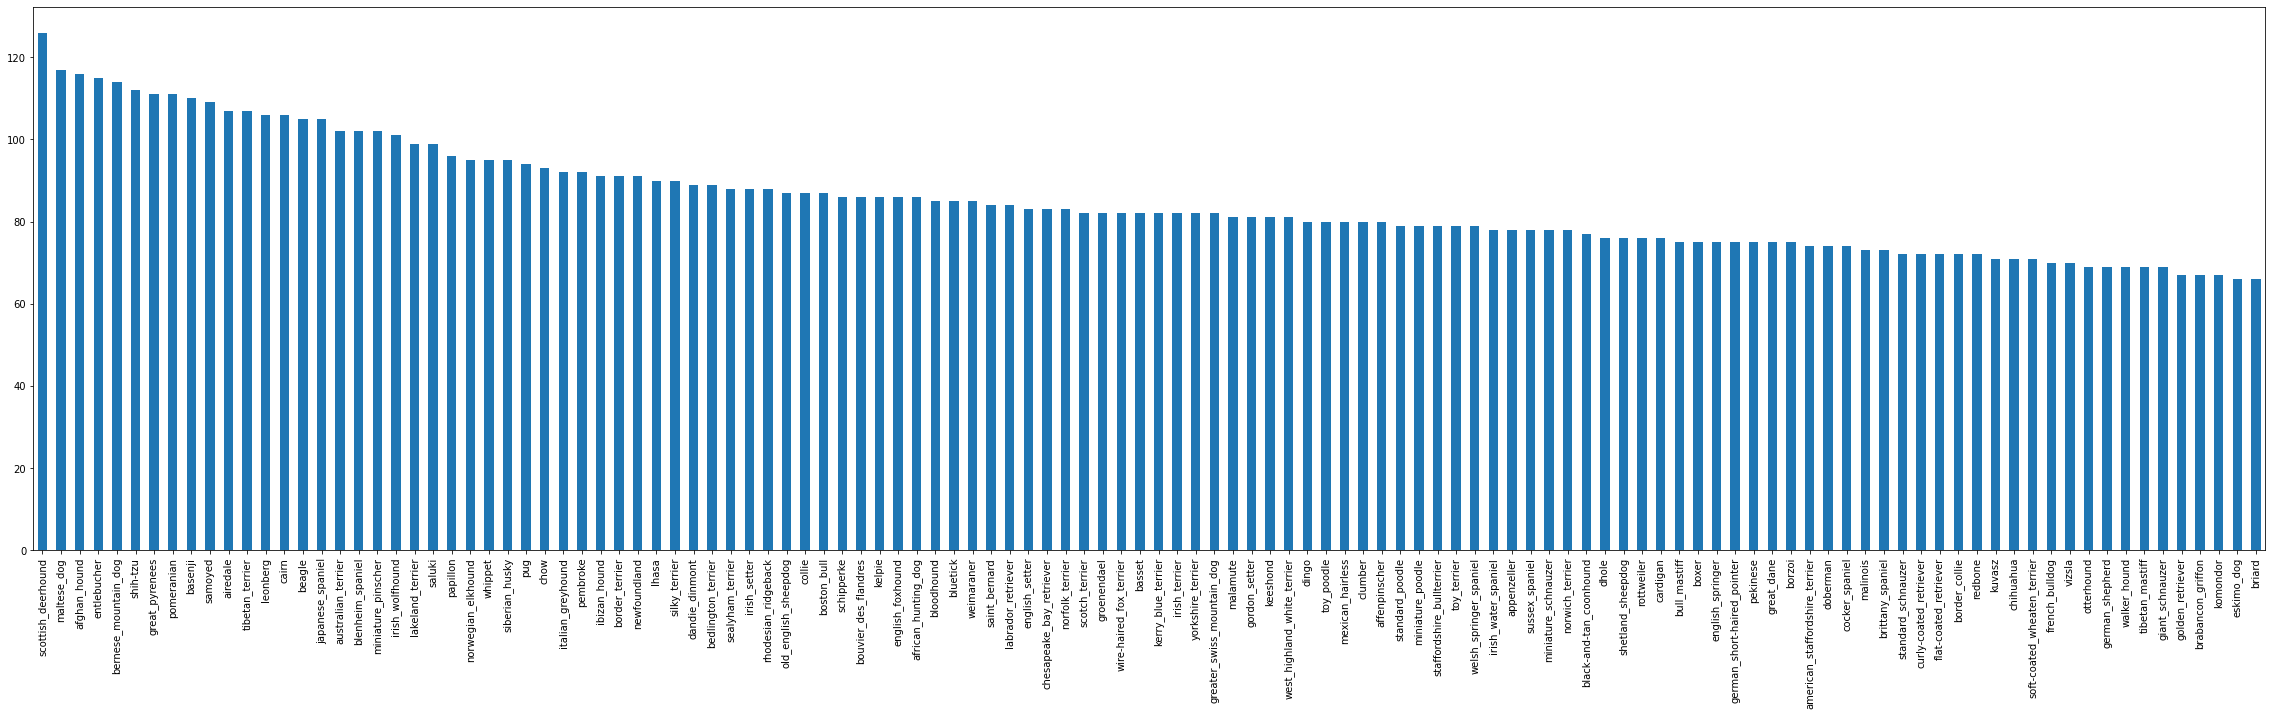

In [6]:
#How many pictures do we have for each breed?
labels["breed"].value_counts().plot.bar(figsize = (40,10))

In [7]:
labels["breed"].value_counts().median()

82.0

In [8]:
labels["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [12]:
#View an image
from IPython.display import Image
Image(data = "/content/drive/MyDrive/dog_breed_classification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

FileNotFoundError: ignored

FileNotFoundError: ignored

<IPython.core.display.Image object>

In [10]:
#Get a list of all images pathnames
train_directory = "drive/MyDrive/dog_breed_classification/train/"


filenames = [train_directory + fname + "jpg" for fname in labels["id"]]
filenames[:5]


['drive/MyDrive/dog_breed_classification/train/000bec180eb18c7604dcecc8fe0dba07jpg',
 'drive/MyDrive/dog_breed_classification/train/001513dfcb2ffafc82cccf4d8bbaba97jpg',
 'drive/MyDrive/dog_breed_classification/train/001cdf01b096e06d78e9e5112d419397jpg',
 'drive/MyDrive/dog_breed_classification/train/00214f311d5d2247d5dfe4fe24b2303djpg',
 'drive/MyDrive/dog_breed_classification/train/0021f9ceb3235effd7fcde7f7538ed62jpg']

In [11]:
# Verify our results for filenames

import os
if len([os.path.join(train_directory,file) for file in os.listdir(train_directory)]) == len(filenames):
  print("Filenames are correct")
else:
  print("Filenames are not correct")

FileNotFoundError: ignored

In [ ]:
if ([os.path.join(train_directory,file) for file in os.listdir(train_directory)]).all() == filenames:
  print("Correct")
else:
  print ("Not correct")